## Playing around with flows

This notebook shows some first steps using flows.

In [2]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  False


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0-rc0
TF  Version 2.0.0-rc0


### Change of variables numerical

 

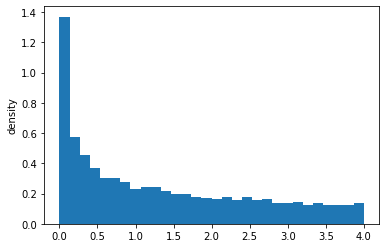

In [4]:
N = 10000
d = tfd.Uniform(low=0, high=2)
zs = d.sample(N)
x = zs**2

plt.hist(x, density=True, bins=30)
plt.ylabel('density')
plt.show()

### The Bijector package tfp.bijectors

Let's take the square as a bijector

z -- f(z)=z^2 --> x

In [5]:
f = tfb.Square() # This is a bijector
f.forward(2.0) #4
f.inverse(4.0) #2

<tf.Tensor: id=33, shape=(), dtype=float32, numpy=2.0>

Let's use the uniform distribution as a base transformation 

In [6]:
base_dist = tfd.Uniform(0.0,2.0)
mydist = tfd.TransformedDistribution(distribution=base_dist, bijector=f)

In [7]:
mydist.prob(3)

<tf.Tensor: id=80, shape=(), dtype=float32, numpy=0.14433756>

(0, 1)

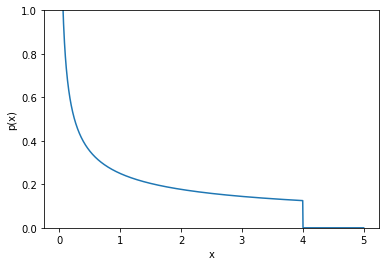

In [8]:
xs = np.linspace(0.001, 5,1000)
ps = mydist.prob(xs)
plt.plot(xs,ps)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.ylim(0,1)

## Using several bijectors

In [9]:
chain = tfb.Chain([tfb.Square(), tfb.Square()], name="x4")
chain.forward(2.0)

<tf.Tensor: id=148, shape=(), dtype=float32, numpy=16.0>

# Training Bijectors

An extremly simple example, to go from a $N(0,1)$ Gaussian to a $N(5.0,0.2)$ Gaussian. 

#### Training Data
Let's sample some training data of our traget distribution:

(1000,)

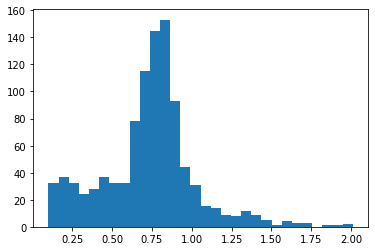

In [49]:
N = 1000
X1 = tfd.Normal(loc=-.5,scale=0.5).sample(N//2)
X2 = tfd.Normal(loc=.7,scale=0.1).sample(N//2)
X1 = X1.numpy().reshape([N//2,1])
X2 = X2.numpy().reshape([N//2,1])
X = np.append(X1,X2)
X = np.abs(X) + 0.1
plt.hist(X,30)
X.shape

#### The simplest flow 


Building the flow using an Affine transformation in 1-D. Simply shift ($b$) and scale ($a$).

$$
    x = a \cdot z + b
$$


In [83]:
#Making a distribution using the flow and a N(0,1)
bijectors = []
for i in range(2):
    bijectors.append(tfb.AffineScalar(shift=tf.Variable(0.0+i/10.0,name="s_{}".format(i)), scale=tf.Variable(1.0,name="sc_{}".format(i))))
    if i < 2:
        bijectors.append(tfb.Softplus())
    
bijector = tfb.Chain(bijectors, name="x4")


dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0,scale=1),bijector=bijector)
dist.trainable_variables,-tf.reduce_mean(dist.log_prob(X))

((<tf.Variable 'sc_0:0' shape=() dtype=float32, numpy=1.0>,
  <tf.Variable 's_0:0' shape=() dtype=float32, numpy=0.0>,
  <tf.Variable 'sc_1:0' shape=() dtype=float32, numpy=1.0>,
  <tf.Variable 's_1:0' shape=() dtype=float32, numpy=0.1>),
 <tf.Tensor: id=1424103, shape=(), dtype=float32, numpy=nan>)

In [95]:
np.exp(np.exp(2))

1618.1779919126539

In [104]:
b1 = tfb.AffineScalar(shift=tf.Variable(0.0), scale=tf.Variable(0.1))
b2 = tfb.AffineScalar(shift=tf.Variable(0.0), scale=tf.Variable(0.1))
b3 = tfb.AffineScalar(shift=tf.Variable(0.0), scale=tf.Variable(0.1))
b4 = tfb.AffineScalar(shift=tf.Variable(0.0), scale=tf.Variable(0.1))
b5 = tfb.AffineScalar(shift=tf.Variable(0.0), scale=tf.Variable(1.0))
b6 = tfb.AffineScalar(shift=tf.Variable(0.0), scale=tf.Variable(1.0))

chain = tfb.Chain([b1, tfb.Exp(), b2,tfb.Exp(), b3], name="x4")
dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0,scale=1),bijector=chain)
dist.trainable_variables,-tf.reduce_mean(dist.log_prob(X))

((<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,
  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,
  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,
  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,
  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,
  <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>),
 <tf.Tensor: id=1926777, shape=(), dtype=float32, numpy=420.85828>)

### Training in eager mode

What shall be the result? 

$z \sim N(0,1) \overbrace{\longrightarrow}^{f(z) = a\cdot z + b} x \sim N(5,0.2)$. 

Hence, $b = 5$ and $a = 0.2$

In [107]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) #quite high lr for normalizing flows.

for i in range(1000):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X)) 
        gradients = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(gradients, dist.trainable_variables))
    if (i % 100 == 0):
        print(i, "NLL ",loss.numpy(), " shift (a) ", shift1.numpy(), " scale (b) ", scale1.numpy())

0 NLL  89.11435  shift (a)  -1.2008388  scale (b)  1.4753207
100 NLL  72.35605  shift (a)  -1.2008388  scale (b)  1.4753207
200 NLL  60.39625  shift (a)  -1.2008388  scale (b)  1.4753207
300 NLL  51.47332  shift (a)  -1.2008388  scale (b)  1.4753207
400 NLL  44.56962  shift (a)  -1.2008388  scale (b)  1.4753207
500 NLL  39.075794  shift (a)  -1.2008388  scale (b)  1.4753207
600 NLL  34.604908  shift (a)  -1.2008388  scale (b)  1.4753207
700 NLL  30.8995  shift (a)  -1.2008388  scale (b)  1.4753207
800 NLL  27.781591  shift (a)  -1.2008388  scale (b)  1.4753207
900 NLL  25.124386  shift (a)  -1.2008388  scale (b)  1.4753207


(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.2088291>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.13768265>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.23332375>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.123467036>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.22294506>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1503837>)

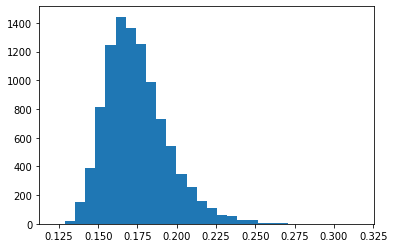

In [108]:
XX = dist.sample(10000)
XX = XX.numpy().reshape([10000,1])
plt.hist(XX,30)
dist.trainable_variables

In [55]:
dist.mean()#dist.stddev() not implemented for transformed model

NotImplementedError: mean is not implemented for non-affine bijectors